In [1]:
library(data.table)
library(limma)
library(dplyr)
library(edgeR)
library(tibble)
library(biomaRt)
library(tidyr)
library(stringr)
library(gtools)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
## Import gene names

In [3]:
ensembl = useEnsembl(biomart="ensembl", dataset="rnorvegicus_gene_ensembl", version=100)

In [4]:
gene_annot <- getBM(mart=ensembl, attributes=c('ensembl_gene_id', 'external_gene_name'))

In [5]:
base_dir <- "../../"
species <- 'rn'
save_dir <- file.path(base_dir, 'DE_and_abundance', '2022_03_18_analysis', 'tumor_and_lungs')
meta_path <- file.path(base_dir, "tumor_region_metadata.csv")
counts_path <- file.path(base_dir, "feature_counts", paste0("tumor_trimmed_gene_counts_", species, '.csv'))
annot_path <- file.path(base_dir, "feature_counts", paste0("tumor_trimmed_FC_gene_annot_", species, '.csv'))

In [6]:
FC_annot <- read.csv(annot_path, row.names=1)
## Select only gene id and length. Note that dplyr will drop row names upon select
## but edgeR expects gene id in row names, so convert gene_id to column, then back, 
## to row names after selecting
FC_annot <- rownames_to_column(FC_annot, var='gene_id')
FC_annot <- dplyr::select(FC_annot, 'gene_id', 'Length')
FC_annot <- column_to_rownames(FC_annot, var='gene_id')

In [7]:
meta <- read.csv(meta_path)

In [8]:
counts <- read.csv(counts_path, row.names=1)

In [9]:
## Change meta sample names to be acceptable variable names

In [10]:
meta$Sample <- paste0('X', meta$Sample)
meta$Sample <- gsub('-', '.', meta$Sample)
meta$RatID <- factor(meta$RatID)

In [11]:
## Take counts in the filtered sample list 

In [12]:
counts <- dplyr::select(counts, meta$Sample)

In [13]:
## Get differential gene expression list for use in limma

In [14]:
y <- DGEList(counts, genes=FC_annot)

In [15]:
## Define the linear model and get the design matrix

In [16]:
design <- model.matrix(~ 0 + Region + RatID, data=meta)

In [17]:
## Filter the data to remove low expressed genes

In [18]:
keep <- filterByExpr(y, design, min.count=10, min.total.count=15)
y <- y[keep, keep.lib.sizes=FALSE]

In [19]:
## Calculate library normalization factors 

In [20]:
y <- calcNormFactors(y)

In [21]:
y$samples

,group,lib.size,norm.factors
,<fct>,<dbl>,<dbl>
X3869out,1,5260576,0.9604118
X3877in,1,3966109,0.9996037
X3875out,1,4900651,0.9168090
X3876lung,1,8511553,1.0918005
X3867out,1,5184313,0.9580453
X3869in,1,3436848,0.9233178
X3875lung,1,10015352,1.0758364
X3869lung,1,6976025,1.0663542
X3877out,1,5138129,0.9996424


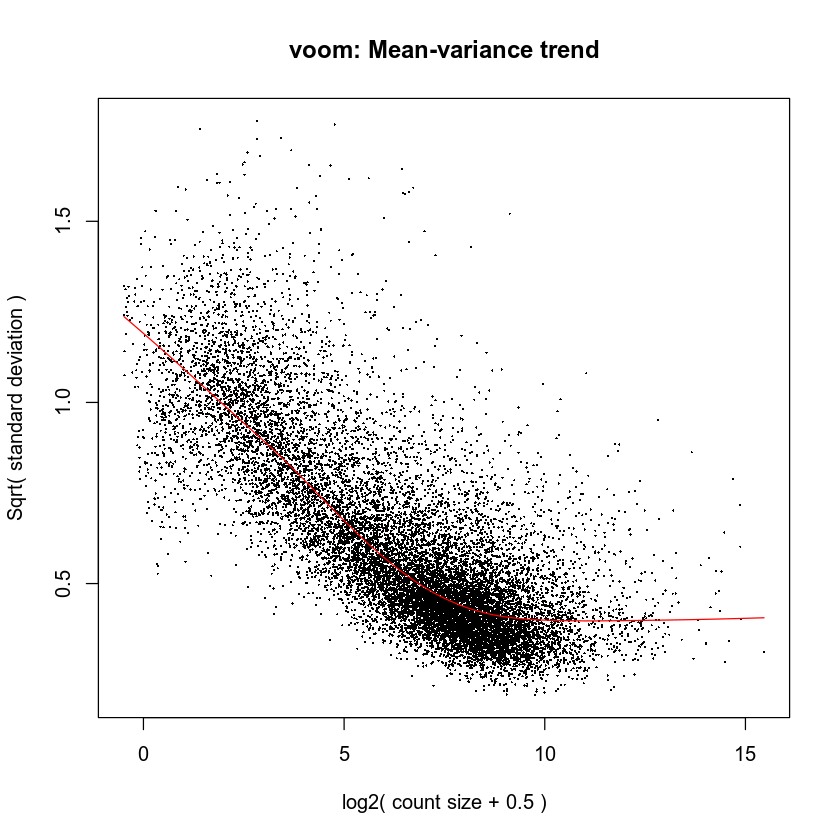

In [22]:
v <- voom(y,design, plot=TRUE)

In [23]:
## Fit the linear model and perform empirical Bayes smoothing

In [24]:
fit <- lmFit(v,design)
fit <- eBayes(fit)

In [25]:
## Get contrasts for pair-wise comparisons
contr <- c('Regionin-Regionlung', 'Regionin-Regionout', 'Regionout-Regionlung')
contrast.matrix <- makeContrasts(contrasts=contr, levels=design)

In [26]:
design

,Regionin,Regionlung,Regionout,RatID3867,RatID3869,RatID3875,RatID3876,RatID3877
1,0,0,1,0,1,0,0,0
2,1,0,0,0,0,0,0,1
3,0,0,1,0,0,1,0,0
4,0,1,0,0,0,0,1,0
5,0,0,1,1,0,0,0,0
6,1,0,0,0,1,0,0,0
7,0,1,0,0,0,1,0,0
8,0,1,0,0,1,0,0,0
9,0,0,1,0,0,0,0,1
10,0,0,1,0,0,0,1,0


In [27]:
## Fit coefficients for contrasts

In [28]:
fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)

In [29]:
## Get abundance from log-transformed CPM

In [30]:
voom_counts <- as.data.frame(v$E)
abundance <- 2.**(data.table::copy(voom_counts))
abundance <- dplyr::select(abundance,mixedorder(colnames(abundance)))
abundance <- rownames_to_column(abundance, var='ensembl_gene_id')

In [31]:
## Get RPKM and convert to TPM

In [32]:
RPKM <- as.data.frame(data.table::copy(rpkm(y)))
TPM <- sweep(RPKM, 2, colSums(RPKM), '/')*(1.e6)
TPM <- dplyr::select(TPM,mixedorder(colnames(TPM)))
TPM <- rownames_to_column(TPM, var='ensembl_gene_id')

In [33]:
## Get top table with logFC and FDR

In [34]:
top_table <- topTable(fit2, coef='Regionin-Regionout', number=Inf, sort.by="P", confint=TRUE)
head(top_table)

,Length,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,B
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSRNOG00000007916,3635,-1.729024,-1.896869,-1.561179,5.717021,-22.55955,7.299565e-11,5.617772e-07,15.52222
ENSRNOG00000004290,5221,-2.716006,-2.980463,-2.451549,5.804994,-22.49119,7.552799e-11,5.617772e-07,15.48177
ENSRNOG00000007518,3282,-1.626159,-1.795724,-1.456595,6.648315,-21.00220,1.628930e-10,6.622347e-07,14.75723
ENSRNOG00000021856,655,1.712868,1.532264,1.893472,5.574644,20.76987,1.845074e-10,6.622347e-07,14.63109
ENSRNOG00000017606,2521,1.775353,1.584434,1.966272,4.978050,20.36443,2.300584e-10,6.622347e-07,14.38819
ENSRNOG00000014170,2898,-1.644903,-1.828274,-1.461532,6.137255,-19.64474,3.439427e-10,6.622347e-07,14.01378


In [35]:
for (contrast in contr){
    top_table <- topTable(fit2, coef=contrast, number=Inf, sort.by="t", confint=TRUE)
    top_table <- rownames_to_column(top_table, var='ensembl_gene_id')
    top_table <- left_join(top_table, gene_annot, by='ensembl_gene_id')
    top_table <- dplyr::select(top_table, ensembl_gene_id, external_gene_name, everything())
    
    top_table_with_abundance <- left_join(top_table, abundance, by='ensembl_gene_id')
    top_table_with_TPM <- left_join(top_table, TPM, by='ensembl_gene_id')
    contrast_label <- str_remove_all(contrast, 'Region')
    
     # Save top table with CPM abundance
    filename <- paste0('toptable_and_CPM_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables_with_CPM_abundance', filename)
    write.csv(top_table_with_abundance, savepath, row.names=FALSE)
    
    # Save top table with TPM abundance
    filename <- paste0('toptable_and_TPM_', species, '_', contrast_label, '.csv')
    savepath <- file.path(save_dir, 'top_tables_with_TPM_abundance', filename)
    write.csv(top_table_with_TPM, savepath, row.names=FALSE)
    
    # save top table with no abundance
    filename <- paste0('toptable_',species,'_', contrast, '.csv')
    savepath <- file.path(save_dir, 'top_tables', filename)
    write.csv(top_table, savepath, row.names=FALSE)
}

In [36]:
head(top_table_with_abundance)
print(savepath)

,ensembl_gene_id,external_gene_name,Length,logFC,CI.L,CI.R,AveExpr,t,P.Value,adj.P.Val,⋯,X3869out,X3875in,X3875lung,X3875out,X3876in,X3876lung,X3876out,X3877in,X3877lung,X3877out
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSRNOG00000014851,Col4a4,10929,-4.598349,-4.872898,-4.323800,4.835078,-36.67915,2.973766e-13,4.423774e-09,⋯,6.432688,9.062144,296.847821,17.916912,10.658076,249.598652,11.04846,10.720037,393.169926,14.894012
2,ENSRNOG00000014170,Dbn1,2898,2.778001,2.582172,2.973830,6.137255,31.06648,1.964046e-12,1.460857e-08,⋯,229.894373,67.886586,26.404003,197.753743,50.818943,26.310356,160.61091,49.816644,19.212020,147.674612
3,ENSRNOG00000008412,Gprc5a,2092,-5.329575,-5.723396,-4.935754,3.883093,-29.63675,3.351435e-12,1.661865e-08,⋯,6.432688,4.928534,201.255120,6.120684,4.479481,257.023661,6.15013,4.414133,278.330754,4.769978
4,ENSRNOG00000004554,Dcn,1862,4.989053,4.590904,5.387201,9.020359,27.44165,8.011594e-12,2.979512e-08,⋯,1715.944266,678.070939,87.471962,3499.362101,618.631813,66.663662,2142.47661,470.798817,66.078524,1851.822115
5,ENSRNOG00000007300,C1qtnf6,2966,4.386886,3.988783,4.784989,5.568034,24.13224,3.419276e-11,7.111994e-08,⋯,239.790816,38.315380,9.976908,351.327275,35.681385,11.890774,182.81669,26.863152,5.357718,135.603649
6,ENSRNOG00000003720,Prrx1,862,3.925466,3.567550,4.283382,4.547530,24.01857,3.606096e-11,7.111994e-08,⋯,98.667538,26.550492,7.192655,118.963844,14.983093,7.478813,75.05335,9.711093,2.976510,73.301900


[1] "../..//DE_and_abundance/2022_03_18_analysis/tumor_and_lungs/top_tables/toptable_rn_Regionout-Regionlung.csv"


In [37]:
##################################
## Create tidy TPM and counts
#################################

In [38]:
## Cast the TPM table into tidy format and add sample info

In [39]:
RPKM <- data.table::copy(rpkm(y))
TPM2 <- sweep(RPKM, 2, colSums(RPKM), '/')*(1.e6)
TPM2 <- rownames_to_column(as.data.frame(TPM2), var='ensembl_gene_id')

In [40]:
TPM.tidy <- pivot_longer(TPM2, -ensembl_gene_id, names_to='Sample', values_to='TPM')
TPM.tidy <- left_join(TPM.tidy, meta, by='Sample')
TPM.tidy <- left_join(TPM.tidy, gene_annot, by='ensembl_gene_id')
TPM.tidy <- dplyr::select(TPM.tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [41]:
filename <- paste0('TPM_', species, '.csv')
savefile <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(TPM.tidy, savefile)

In [42]:
## Get the voom normalized counts per million

In [43]:
voom_cpm <- v$E
voom_cpm2 <- 2**voom_cpm
voom_cpm3 <- rownames_to_column(as.data.frame(voom_cpm2), var='ensembl_gene_id')
voom_cpm_tidy <- pivot_longer(voom_cpm3, -ensembl_gene_id, names_to='Sample', values_to='CPM')
voom_cpm_tidy <- left_join(voom_cpm_tidy, meta, by='Sample')
voom_cpm_tidy <- left_join(voom_cpm_tidy, gene_annot, by='ensembl_gene_id')
voom_cpm_tidy <- dplyr::select(voom_cpm_tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())
filename <- paste0('cpm_voom_tidy_',species, '.csv')
voom_cpm_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(voom_cpm_tidy, voom_cpm_save_file, row.names=FALSE)

In [44]:
## Get tidy raw counts`

In [45]:
counts2 <- rownames_to_column(counts, var='ensembl_gene_id')
genes <- gene_annot['ensembl_gene_id']
counts2 <- dplyr::filter(counts2, ensembl_gene_id %in% gene_annot$ensembl_gene_id)
counts.tidy <- pivot_longer(counts2, -ensembl_gene_id, names_to='Sample', values_to='Counts')
counts.tidy <- left_join(counts.tidy, meta, by='Sample')
counts.tidy <- left_join(counts.tidy, gene_annot, by='ensembl_gene_id')
counts.tidy <- dplyr::select(counts.tidy, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [46]:
# Save tidy counts table

In [47]:
filename <- paste0('Unfiltered_counts_tidy_', species, '.csv')
counts_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(counts.tidy, counts_save_file, row.names=FALSE)

In [48]:
## Merge 

In [49]:
TPM_counts_tidy <- left_join(TPM.tidy, counts.tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))

In [50]:
TPM_cpm_tidy <- left_join(TPM.tidy, voom_cpm_tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))

In [51]:
TPM_counts_cpm <- left_join(TPM_cpm_tidy, counts.tidy, by=append(c('ensembl_gene_id', 'external_gene_name'),colnames(meta)))
TPM_counts_cpm <- dplyr::select(TPM_counts_cpm, ensembl_gene_id, external_gene_name, colnames(meta), everything())

In [52]:
## Merge tidy table

In [53]:
filename <- paste0('TPM_CPM_counts_', species, '.csv')
tpm_cpm_cts_save_file <- file.path(save_dir, 'tidy_abundance_tables', filename)
write.csv(TPM_counts_cpm, tpm_cpm_cts_save_file, row.names=FALSE)